# CS486 - Artificial Intelligence
## Lesson 6 - Constraint Satisfaction Problems

The path from a start node to a goal node in a search tree problem can be more important than the goal itself. For instance, the path from Arad to Bucharest *is* the solution to the Romania search problem. 

CSPs take a different apprach by focusing on the solution itself and less on the path taken to get there. Map coloring is a good example: We just want a valid coloring of map, we don't really care how we obtained the coloring.  

CSPs define a set of **variables** that are assigned values within their respective **domains**. Assignments between **neighbors** must satisfy a set of **constraints**. A lot of problems can be formulated as a CSPs, which makes them popular. There are a lot of general-purpose CSP solvers available and they are frequently used to find or approximate solutions to known hard problems.  

Let's take a look at how we can use the AIMA library to articulate a CSP and the various methods available to solve it. Before we get started, import the CSP library form AIMA:

In [1]:
from helpers import print_puzzle
from aima.csp import *

# for generatoring graphs
import networkx as nx
%matplotlib inline

Here's the documentation for the CSP class:

In [2]:
%pdoc CSP

Class docstring:
    This class describes finite-domain Constraint Satisfaction Problems.
    A CSP is specified by the following inputs:
        variables   A list of variables; each is atomic (e.g. int or string).
        domains     A dict of {var:[possible_value, ...]} entries.
        neighbors   A dict of {var:[var,...]} that for each variable lists
                    the other variables that participate in constraints.
        constraints A function f(A, a, B, b) that returns true if neighbors
                    A, B satisfy the constraint when they have values A=a, B=b
    
    In the textbook and in most mathematical definitions, the
    constraints are specified as explicit pairs of allowable values,
    but the formulation here is easier to express and more compact for
    most cases. (For example, the n-Queens problem can be represented
    in O(n) space using this notation, instead of O(N^4) for the
    explicit representation.) In terms of describing the CSP as a
    pr

# Map Coloring

So we need four things that every CSP problem needs: **variables**, **domains**, **neighbors**, and **contraints**. Let's see how we would build a solution to a trivial map coloring problem. 

Suppose we want to assign each node in a graph a color - *red, blue or green* - such that no two connected nodes share a color. Consider the 3-node cycle graph, pictured below. Let's see how we would solve this simple case using the CSP class. 

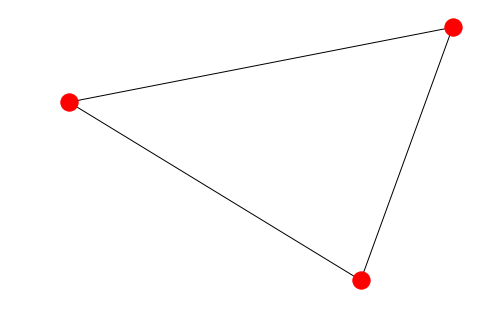

In [3]:
nx.draw(nx.cycle_graph(3))

The variables are the things we want to assign. In this case, the nodes. The domains are the valid assignments that can be made to each variable. Neighbors are the sets of variables impacted by each other's assignments. Finally, the constraint method or lambda returns **`True`** if two neighbors have assignments that do not conflict.

Below is a CSP instance for our simple map coloring problem.

In [4]:
variables = ['A','B','C']

domains = {
    'A': ['red','green','blue'],
    'B': ['red','green','blue'],
    'C': ['red','green','blue']
}

neighbors = {
    'A': ['B','C'],
    'B': ['A','C'],
    'C': ['A','B']
}

def constraints(A,a,B,b):
    return a!=b

coloring = CSP(variables,domains,neighbors,constraints)

Before continuing consider the following question: 
* What kind of contraints does our CSP require? Implcit? Explicit? Unary? Binary? n-ary? 

# Backtracking

So how do we actually solve the CSP? We need an algorithm for exploring possible solutions. *Backtracking* is the uninformed search algorithm for CSPs. It is essentially a depth-first search with goal checks at every assignment. Let's apply backtracking to our problem:

In [5]:
backtracking_search(coloring)

{'A': 'red', 'B': 'green', 'C': 'blue'}

So how does backtracking work? To get a better idea of how the algorithm works, **[run the Backtracking Visualization from the AIMA website](http://aimacode.github.io/aima-javascript/6-Constraint-Satisfaction-Problems/#backtracking-search)**. 

How many times did the algorithm have to backtrack on our coloring problem? We can check the number of times a variable assignment was made by looking at the *`nassign`* attribute on our CSP:

In [6]:
coloring.nassigns

3

It's not an intuitive result. The algorithm checked the constraints for a lot of potential variable assignments, but the only assignments it *actually* made were those that passed the `constraints` test.

# Edge Matching

Edge matching puzzles, such as the one below, are typically square and have pieces whose edges are distinguished with colors or patterns, in such a way that the edges of adjacent tiles match. Edge matching puzzles are NP-complete but can be easily formulated as a CSP. 

<img width="400px" src='http://origin2images-rainbowresource.netdna-ssl.com/products/015176.jpg'>

Below are the pieces and skeleton of a 4x4 edge matching puzzle CSP. Assign values to **`variables`**, **`domains`**, **`neighbors`**, and define the **`constraints`** method. 

In [7]:
pieces = [
    ('B', 'P', 'O', 'Y'),
    ('W', 'B', 'P', 'R'),
    ('Y', 'B', 'G', 'W'),
    ('Y', 'G', 'B', 'R')
]

print_puzzle(pieces)

    B        W    
  Y   P    R   B  
    O        P    

    Y        Y    
  W   B    R   G  
    G        B    



In [8]:
variables = []
domains = {}
neighbors = {}

def constraints(A,a,B,b):
    return True
    
scramble = CSP(variables,domains,neighbors,constraints)

The cell below will solve the CSP using **`backtracking_search`** function and print the number of assignments needed to find the solutions. 

In [9]:
print_puzzle(backtracking_search(scramble))
print("Solution found in", scramble.nassigns, "assignments")

Solution found in 0 assignments


# Improved Backtracking

There are three ways we can improve our backtracking search:
* Inference
* Ordering variables
* Ordering values

## Inference

Every time an assignment is made, we can remove values from the domains of neighboring variables that will break constraints, which can save us some backtracking. 

```python
backtracking_search(csp,inference=forward_checking)
```

Walk through the following map coloring problem. How does forward checking save us from backtracking?

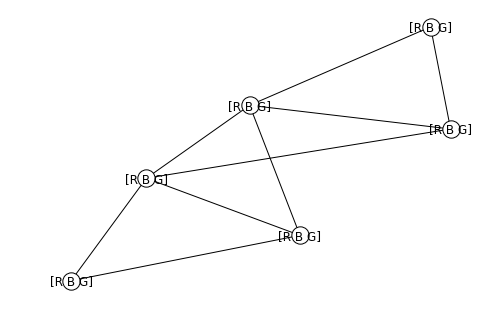

In [10]:
map = nx.triangular_lattice_graph(1,4)
labels = {(x,y): "[R B G]" for x in range(3) for y in range(2)}
nx.draw_kamada_kawai(map,labels=labels,node_color='white',edgecolors='black')

**Arc consistency** is recursively applying forward checking to every edge in the graph every time an assignment is made. It is effective, but can be expensive in a highly connected graph. 

## Ordering variables

By default, backtracking works through variables in the order they were originally given. By prioritizing the assignment of  variables with fewest values can prevent a lot of backtracking. In other words, if only one value can be assigned to a particular variable in the current state of the CSP, then that assignment should be made sooner than later. 

This strategy is called, the *minimum remaining values*. In AIMA, we could add that strategy to our backtracking search:

```python
backtracking_search(csp,select_unassigned_variable=mrv)
```

The has obvious advantages in situations like the one below:

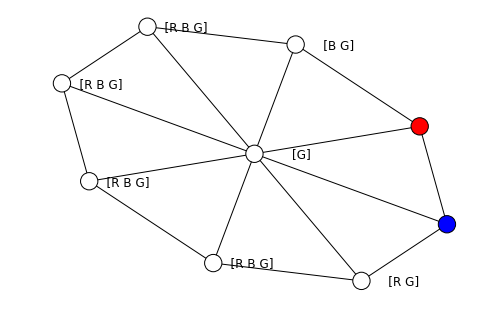

In [11]:
map = nx.wheel_graph(9)
colors=[*['white']*6,'blue','red','white']
labels = {x: "[R B G]".rjust(27) for x in range(8)}
labels[0], labels[6], labels[7] = "[G]".rjust(27),'',''
labels[8], labels[5] = "[B G]".rjust(27), "[R G]".rjust(27)
nx.draw_spectral(map,labels=labels,node_color=colors,edgecolors='black')

## Ordering Values

Similar advantages can be gained by choosing values that, when assigned, results in the fewest number of constraints. This strategy is called the *least constraining value*. In the example below, which assignment is the least constraining?

<img src="https://s33.postimg.cc/go930p58f/lcv.png">

# Benchmarking

So how much do time can these improvements shave of our backtracking search? To benchmark it, we need a bigger problem. Modify your CSP to solve the following 4x4 puzzle:

In [12]:
pieces = [
    (0,3,4,5),
    (7,9,8,0),
    (8,5,5,9),
    (0,5,0,1),
    
    (4,7,1,8),
    (1,1,8,3),
    (0,0,7,9),
    (8,1,0,3),
    
    (7,8,9,5),
    (9,0,9,8),
    (8,6,7,5),
    (1,9,9,7),
    
    (3,5,7,1),
    (9,3,8,0),
    (2,1,1,3),
    (1,3,2,0)
]

## Baseline 

In [13]:
%%time

scramble = CSP(variables,domains,neighbors,constraints)
assert(backtracking_search(scramble) is not None)
print(scramble.nassigns)

0
CPU times: user 391 µs, sys: 147 µs, total: 538 µs
Wall time: 453 µs


## Forward checking

In [14]:
%%time

scramble = CSP(variables,domains,neighbors,constraints)
assert(backtracking_search(scramble, inference=forward_checking) is not None)
print(scramble.nassigns)

0
CPU times: user 341 µs, sys: 116 µs, total: 457 µs
Wall time: 392 µs


## Arc consistency

In [15]:
%%time

scramble = CSP(variables,domains,neighbors,constraints)
assert(backtracking_search(scramble, inference=mac) is not None)
print(scramble.nassigns)

0
CPU times: user 169 µs, sys: 57 µs, total: 226 µs
Wall time: 266 µs


## Forward checking with MRV

In [16]:
%%time

scramble = CSP(variables,domains,neighbors,constraints)
assert(backtracking_search(scramble, inference=forward_checking, select_unassigned_variable=mrv) is not None)
print(scramble.nassigns)

0
CPU times: user 161 µs, sys: 32 µs, total: 193 µs
Wall time: 204 µs


# Challenge

Perfect 10 is an edge matching puzzle where each edge is a number and adjacent edges must add to 10. With some minor modifications to your CSP, you should be able to solve the Perfect 10 puzzle below.

In [17]:
pieces = [
    (3,2,7,9),
    (7,8,4,1),
    (1,6,8,4),
    
    (2,6,9,3),
    (3,2,6,9),
    (4,2,7,9),
    
    (7,4,2,9),
    (3,4,9,8),
    (1,8,6,3)
]